# BINARY BLACK HOLE SIGNALS IN LIGO OPEN DATA

This notebook is part of the [GWOSC tutorials](https://gwosc.org/tutorials/) and is adapted from this [github page](https://github.com/losc-tutorial/LOSC_Event_tutorial/blob/master/LOSC_Event_tutorial.ipynb).

Version 1.64, 2022 July 05

Welcome! This IPython notebook (or associated python script LOSC_Event_tutorial.py ) will go through some typical signal processing tasks on strain time-series data associated with the LIGO Event data releases from the LIGO Open Science Center (LOSC):

* Find events at https://www.gwosc.org/eventapi/.
* Run this tutorial with Binder using the link on the [tutorials](https://www.gwosc.org/tutorials/) page.
* If you are running this tutorial on your own computer, see the [Download](https://github.com/losc-tutorial/LOSC_Event_tutorial/blob/557a873b7306836faea1a321f1cd9d12745e9692//#Download-the-data) section below.
* After setting the desired "eventname" below, you can just run the full notebook.

Questions, comments, suggestions, corrections, etc: [ask.igwn.org](https://ask.igwn.org/)

### This tutorial is intended for educational purposes. The code shown here is not used to produce results papers published by the LIGO Scientific Collaboration, which instead rely on special purpose analysis software packages.

#### For publicly available, gravitational-wave software analysis packages that are used to produce LSC and Virgo Collaboration results papers, see https://www.gwosc.org/software/.

#### For technical notes on this tutorial, see https://www.gwosc.org/bbh_tutorial_notes/.

### Table of Contents

* Fill in later

### Intro to signal processing

This tutorial assumes that you are comfortable with [python](https://www.python.org/).

This tutorial also assumes that you know a bit about signal processing of digital time series data (or want to learn!). This includes power spectral densities, spectrograms, digital filtering, whitening, audio manipulation. This is a vast and complex set of topics, but we will cover many of the basics in this tutorial.

If you are a beginner, here are some resources from the web:

* http://101science.com/dsp.htm
* https://www.coursera.org/course/dsp
* https://georgemdallas.wordpress.com/2014/05/14/wavelets-4-dummies-signal-processing-fourier-transforms-and-heisenberg/
* https://en.wikipedia.org/wiki/Signal_processing
* https://en.wikipedia.org/wiki/Spectral_density
* https://en.wikipedia.org/wiki/Spectrogram
* http://greenteapress.com/thinkdsp/
* https://en.wikipedia.org/wiki/Digital_filter

And, well, lots more on the web!

### Download the data on a computer with a python installation

If you are using a pre-configured setup (eg, in binder), great! You don't have to download or set up anything.

Otherwise, to begin, get the necessary files, by downloading the zip file and unpacking it into single directory:

LOSC_Event_tutorial.zip
This zip file contains:

* this IPython notebook LOSC_Event_tutorial.ipynb code.
* python code for reading LOSC data files: readligo.py.
* the event data files (32s sampled at 4096 Hz, in hdf5 format, for both LIGO detectors).
* waveform templates (32s sampled at 4096 Hz, in hdf5 format, for both plus and cross polarizations).
* a parameter file in json format

You will also need a python installation with a few packages ([numpy](http://www.numpy.org/), [matplotlib](http://matplotlib.org/), [scipy](https://www.scipy.org/), [h5py](http://www.h5py.org/), [json](https://docs.python.org/2/library/json.html)).

* For hints on software installation, see https://www.gwosc.org/tutorial00/
* The tutorial should work on python 2.6 and above, including python 3, as well as in recent versions of IPython.
* You *might* see Warning or `FutureWarning` messages, which tend to be associated with different versions of python, Ipython, numpy, etc Hopefully they can be ignored!
* the filetype "hdf5" means the data are in hdf5 format:

https://www.hdfgroup.org/HDF5/

* NOTE: GPS time is number of seconds since Jan 6, 1980 GMT. See http://www.oc.nps.edu/oc2902w/gps/timsys.html or https://www.gwosc.org/gps/

### Set the event name to choose event and the plot type

In [11]:
#-- SET ME   Tutorial should work with most binary black hole events
#-- Default is no event selection; you MUST select one to proceed.
eventname = ''
eventname = 'GW150914' 
#eventname = 'GW151226' 
#eventname = 'LVT151012'
#eventname = 'GW170104'

# want plots?
make_plots = 1
plottype = "png"
#plottype = "pdf"
plotfolder = "./figs/"

In [12]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
import readligo as rl

# you might get a matplotlib warning here; you can ignore it.

#### Read the event properties from a local json file (download in advance):

In [13]:
# Read the event properties from a local json file
fnjson = "BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://www.gwosc.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()

In [14]:
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)

Reading in parameters for event GW150914
{'name': 'GW150914', 'fn_H1': 'H-H1_LOSC_4_V2-1126259446-32.hdf5', 'fn_L1': 'L-L1_LOSC_4_V2-1126259446-32.hdf5', 'fn_template': 'GW150914_4_template.hdf5', 'fs': 4096, 'tevent': 1126259462.44, 'utcevent': '2015-09-14T09:50:45.44', 'm1': 41.743, 'm2': 29.237, 'a1': 0.355, 'a2': -0.769, 'approx': 'lalsim.SEOBNRv2', 'fband': [43.0, 300.0], 'f_min': 10.0}


### Read in the data

We will make use of the data, and waveform template, defined above.

In [15]:
#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://www.gwosc.org/s/events/"+eventname)
    print("Quitting.")
    quit()

### Data Gaps

**NOTE** that in general, LIGO strain time series data has gaps (filled with NaNs) when the detectors are not taking valid ("science quality") data. Analyzing these data requires the user to [loop over "segments"](https://www.gwosc.org/timeline/) of valid data stretches.

**In this tutorial, for simplicity, we assume there are no data gaps - this will not work for all times!** See the [notes on segments](https://www.gwosc.org/timeline/) for details.

### First look at the data from H1 and L1

In [16]:
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# Let's look at the data and print out some stuff:

print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())

#What's in chan_dict?  (See also https://www.gwosc.org/tutorials/)
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))

time_H1: len, min, mean, max =  131072 1126259446.0 1126259461.999878 1126259477.9997559
strain_H1: len, min, mean, max =  131072 -7.044665943156067e-19 5.895522509246437e-23 7.706262192397465e-19
strain_L1: len, min, mean, max =  131072 -1.8697138664279764e-18 -1.0522332249909908e-18 -4.60035111311666e-20
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA


1126259462.44


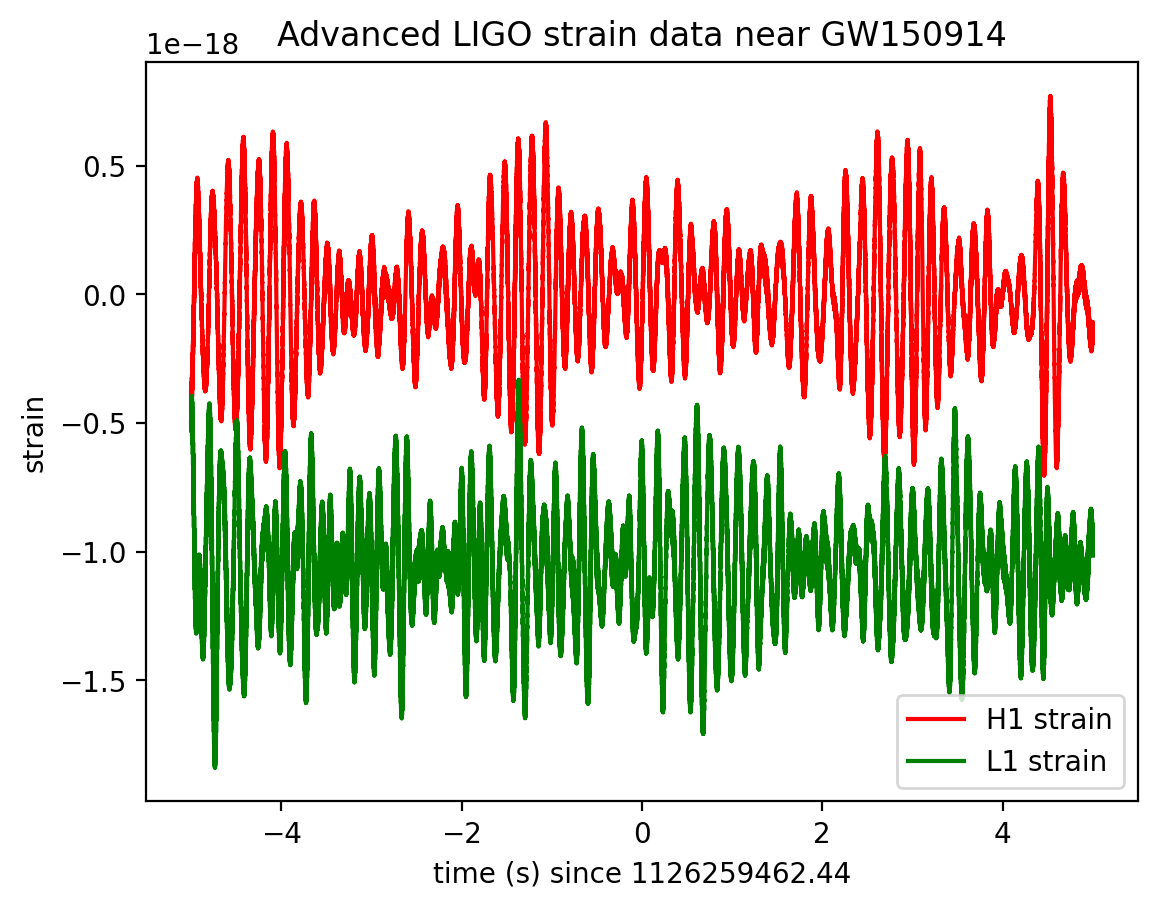

In [17]:
# plot +- deltat seconds around the event:
# index into the strain time series for this time interval:
deltat = 5
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
print(tevent)

if make_plots:
    plt.figure()
    plt.plot(time[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
    plt.plot(time[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('strain')
    plt.legend(loc='lower right')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(plotfolder+eventname+'_strain.'+plottype)

The data are dominated by **low frequency noise**; there is no way to see a signal here, without some signal processing.

### Plot the Amplitude Spectral Density (ASD)

Plotting these data in the Fourier domain gives us an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density, ASD.

The ASDs are the square root of the power spectral densities (PSDs), which are averages of the square of the fast fourier transforms (FFTs) of the data.

They are an estimate of the "strain-equivalent noise" of the detectors versus frequency, which limit the ability of the detectors to identify GW signals.

They are in units of strain/sqrt(Hz). So, if you want to know the root-mean-square (rms) strain noise in a frequency band, integrate (sum) the squares of the ASD over that band, then take the square-root.

There's a signal in these data! For the moment, let's ignore that, and assume it's all noise.

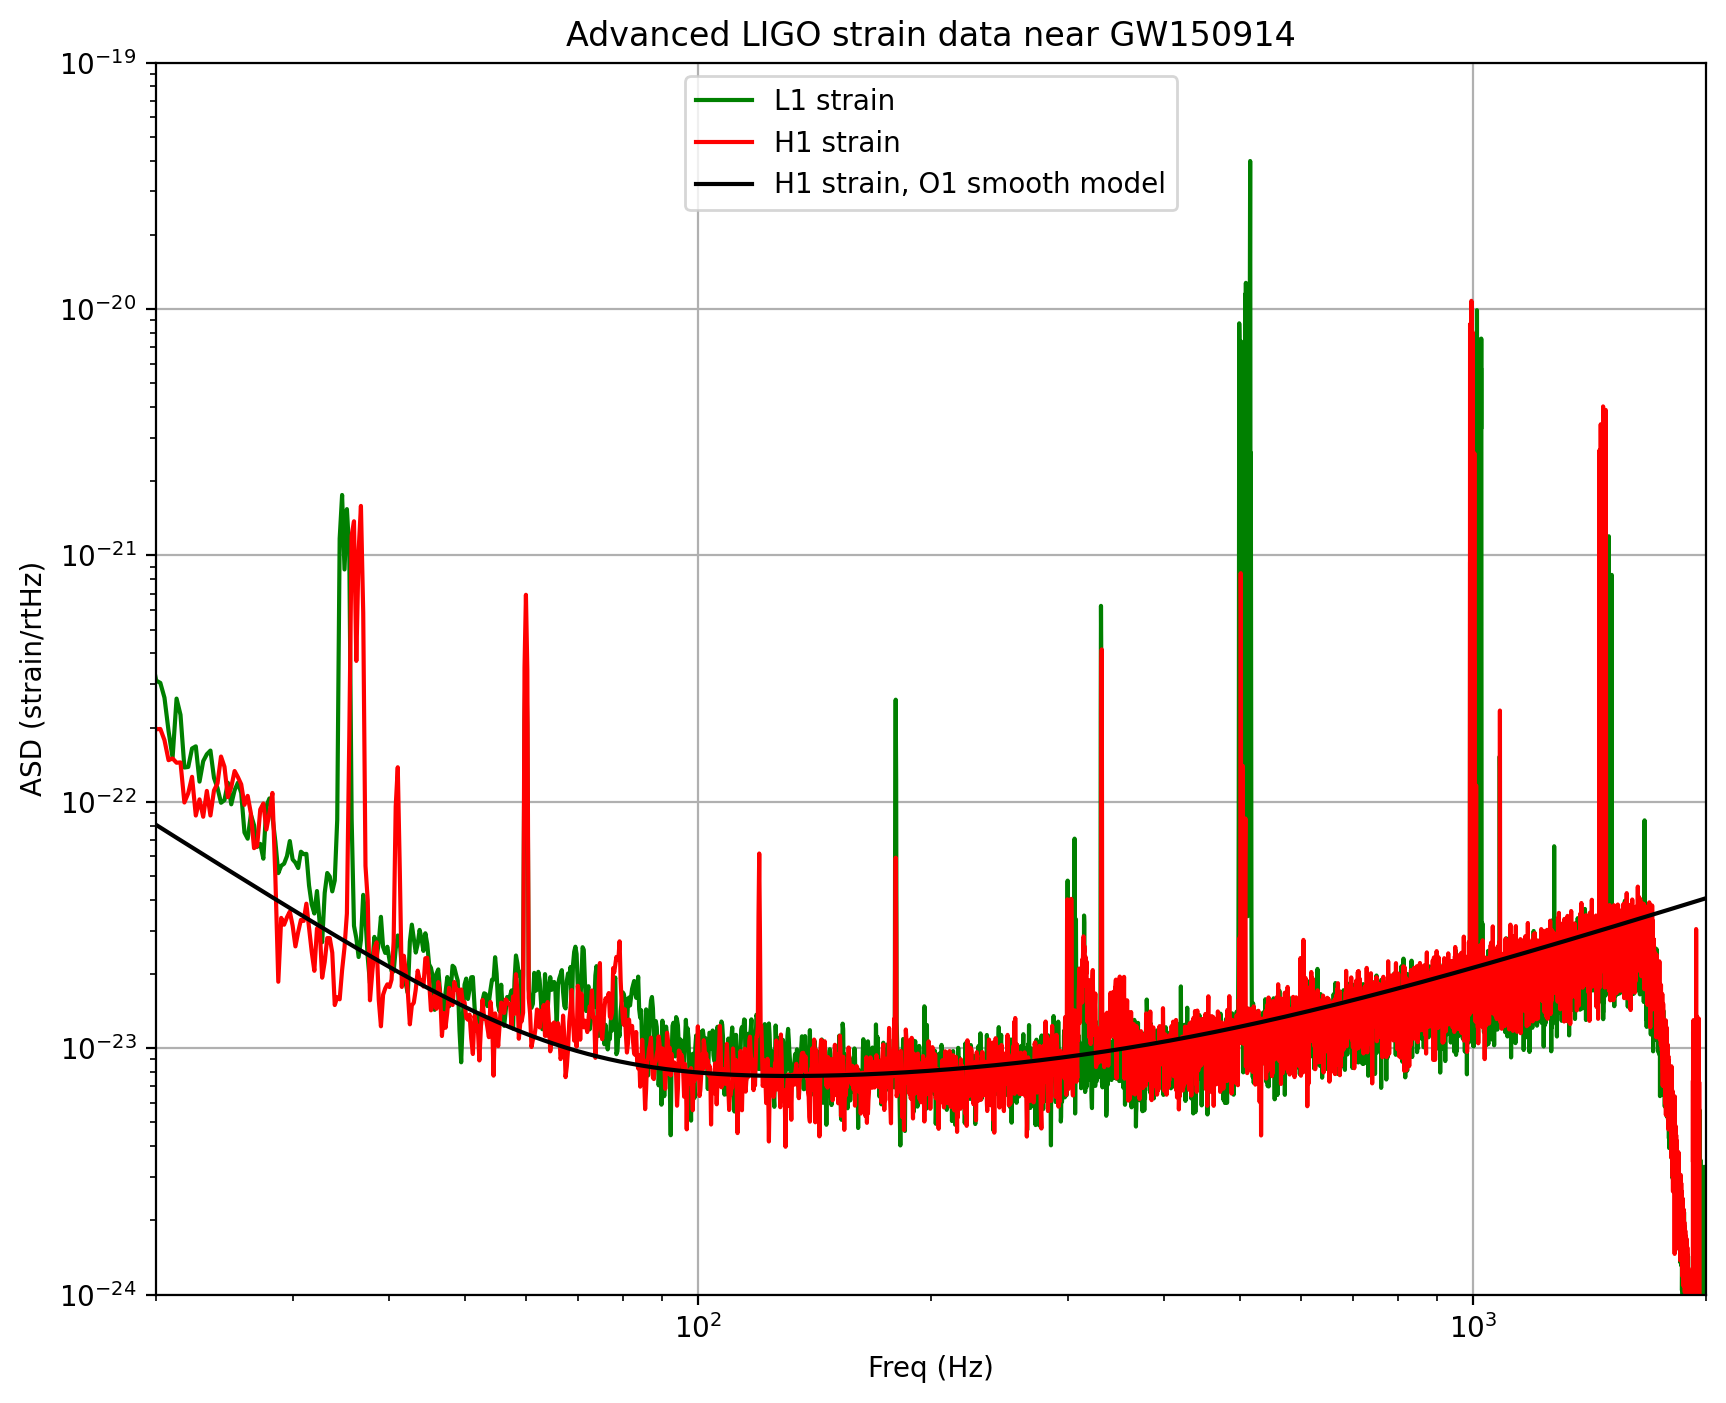

In [18]:
make_psds = 1
if make_psds:
    # number of sample for the fast fourier transform:
    NFFT = 4*fs
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
    Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

    # We will use interpolations of the ASDs computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1)
    psd_L1 = interp1d(freqs, Pxx_L1)

    # Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
    Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
    psd_smooth = interp1d(freqs, Pxx)

if make_plots:
    # plot the ASDs, with the template overlaid:
    f_min = 20.
    f_max = 2000. 
    plt.figure(figsize=(10,8))
    plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
    plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 strain')
    plt.loglog(freqs, np.sqrt(Pxx),'k',label='H1 strain, O1 smooth model')
    plt.axis([f_min, f_max, 1e-24, 1e-19])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(plotfolder+eventname+'_ASDs.'+plottype)

NOTE that we only plot the data between f_min = 20 Hz and f_max = 2000 Hz.

Below f_min, the data **are not properly calibrated**. That's OK, because the noise is so high below f_min that LIGO cannot sense gravitational wave strain from astrophysical sources in that band.

The sample rate is fs = 4096 Hz (2^12 Hz), so the data cannot capture frequency content above the Nyquist frequency = fs/2 = 2048 Hz. That's OK, because our events only have detectable frequency content in the range given by fband, defined above; the upper end will (almost) always be below the Nyquist frequency. We set f_max = 2000, a bit below Nyquist.

You can see strong spectral lines in the data; they are all of instrumental origin. Some are engineered into the detectors (mirror suspension resonances at ~500 Hz and harmonics, calibration lines, control dither lines, etc) and some (60 Hz and harmonics) are unwanted. We'll return to these, later.

You can't see the signal in this plot, since it is relatively weak and less than a second long, while this plot averages over 32 seconds of data. So this plot is entirely dominated by instrumental noise.

The smooth model is hard-coded and tuned by eye; it won't be right for arbitrary times. We will only use it below for things that don't require much accuracy.